#Assignment 3



Install dependencies

In [ ]:
!sudo apt update
#pip install wheel setuptools pip --upgrade

!pip install swig
!pip install box2d-py
!pip install gymnasium[box2d]==0.29

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,630 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,226 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/restricted amd

Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.pyplot import figure

import gymnasium as gym
import torch
from torch.utils import data
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import random
from gymnasium import wrappers
import copy
from gymnasium.wrappers.record_video import RecordVideo

import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



Deep RL Replay Buffer

In [ ]:
class ReplayBuffer:
    def __init__(self, size):
        self.size = size
        self.counter = 0
        self.state_buffer = []
        self.action_buffer = []
        self.reward_buffer = []
        self.new_state_buffer = []
        self.terminal_buffer = []

    def store_tuples(self, state, action, reward, new_state, done):
        if len(self.state_buffer) < self.size:
            self.state_buffer.append(None)
            self.action_buffer.append(None)
            self.reward_buffer.append(None)
            self.new_state_buffer.append(None)
            self.terminal_buffer.append(None)

        self.counter = self.counter % self.size
        self.state_buffer[self.counter] = state
        self.action_buffer[self.counter] = action
        self.reward_buffer[self.counter] = reward
        self.new_state_buffer[self.counter] = new_state
        self.terminal_buffer[self.counter] = done
        self.counter += 1

    def sample_buffer(self, batch_size):
        max_buffer = min(self.counter, self.size)
        batch = np.random.choice(max_buffer, batch_size, replace=False)
        state_batch=[];
        action_batch=[];
        reward_batch=[];
        new_state_batch=[];
        done_batch=[];

        for a in batch:
            state_batch.append(self.state_buffer[a])
            action_batch.append(self.action_buffer[a])
            reward_batch.append(self.reward_buffer[a])
            new_state_batch.append(self.new_state_buffer[a])
            done_batch.append(self.terminal_buffer[a])
        return state_batch, action_batch, reward_batch, new_state_batch, done_batch





Default DQN arquitecture

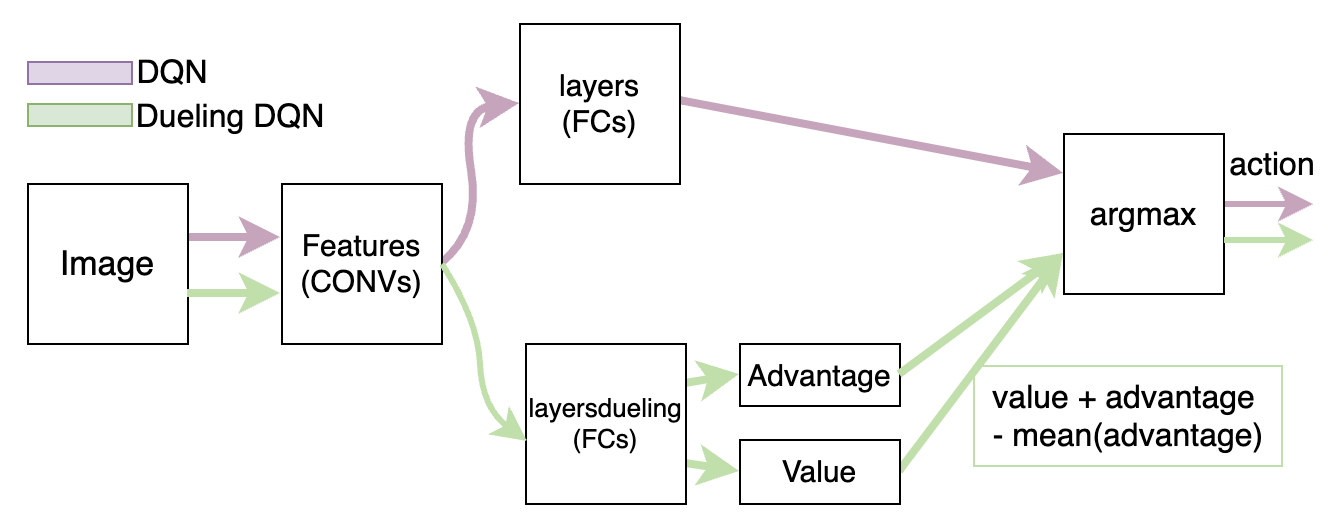

In [ ]:
class DQN(nn.Module):

    def __init__(self, inputs, outputs):
        super(DQN, self).__init__()

        self.input_size=inputs;
        self.output_size=outputs;

        self.features = nn.Sequential(
            nn.Conv2d(inputs, 32, kernel_size=5, stride=2),  # First convolutional layer
            nn.GELU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),     # Second convolutional layer
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Standard DQN path
        self.layers = nn.Sequential(
            nn.Linear(7744, 256),
            nn.GELU(),
            nn.Linear(256, outputs),
        )

        # Dueling network architecture
        self.layersdueling = nn.Sequential(
            nn.Linear(7744, 256),
            nn.GELU(),
        )

        self.advantage = nn.Sequential(
            nn.Linear(256, outputs),
        )

        self.value = nn.Sequential(
            nn.Linear(256, 1),
        )

###### DQN/Double DQN configuration

###########    ############    #################
#         #    #          #    #               #
#   IMG   # -> # features # -> #     layers    #    .... argmax ....
#         #    #  (CONVs) #    #     (FCs)     #
###########    ############    #################


###### Dueling configuration
                                                    #############
###########    ############    #################    # advantage #
#         #    #          #    #               # -> #############   ... value + advantage  - advantage.mean() ... argmax ...
#   IMG   # -> # features # -> # layersdueling # -> #############
#         #    #  (CONVs) #    #     (FCs)     #    #   value   #
###########    ############    #################    #############


    def forward(self, x):

        if(useDueling):
            x=self.features(x)
            x = x.view(x.size(0), -1)
            x = self.layersdueling(x)
            advantage = self.advantage(x)
            value     = self.value(x)
            return value + advantage  - advantage.mean()
        else:
            x=self.features(x)
            x = x.view(x.size(0), -1)
            return self.layers(x)

    def policy(self,state):
       with torch.no_grad():
            return self.__call__(state.unsqueeze(0)).argmax()

    def getPolicy(self,state,eps_threshold):
        sample = random.random()
        if sample > eps_threshold:
            with torch.no_grad():
                return self.__call__(state.unsqueeze(0)).argmax()
        else:
            return  torch.tensor(random.randrange(self.output_size), device=device, dtype=torch.long)


In [ ]:
!pip install torchviz

In [ ]:
from torchviz import make_dot

useDueling=False

model = DQN(3*4,5)
dummy_input = torch.randn(1, 3*4, 96, 96)
make_dot(model(dummy_input), params=dict(model.named_parameters())).render("dqn_architecture", format="png")


'dqn_architecture.png'

In [ ]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/_4mlTeb5VeQ?si=pFHsyireZONVr5tU" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>')



/usr/local/lib/python3.10/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


OpenAI Environment CarRacing-v2
[Sample result](https://www.youtube.com/watch?v=_4mlTeb5VeQ)

###    Description:
        Continuous or discrete control task to learn from pixels, a top-down racing environment.
###    Observation:
        Type: Image (96x96x3)
        Some indicators are shown at the bottom of the window along with the state RGB buffer. From left to right: the true speed, four ABS sensors, the steering wheel position and gyroscope.
###    Actions:
        Discrete Mode: 'nothing','left','right','gas','brake'
        Continuous Mode: 3 different variables can be modified: steering wheel, gas, and brake. For the methods explored in this Colab, discrete control commands are reasonable (a set of control commands is provided for this mode).
###    Reward:
        The reward is -0.1 every frame and +1000/N for every track tile visited, where N is the total number of tiles visited in the track. For example, if you have finished in 732 frames, your reward is 1000 - 0.1*732 = 926.8 points.
###    Starting State:
        The tracks and colors are randomly generated with UseRandomize=True for each episode. With UseRandomize=False, only the tracks are random.
###    Episode Termination:
        Car is too faraway from the track.
        Car accumulated a negative reward after given iterations (see ResetCounter and InitCounter).
        Episode length is greater than 1000.
        All tiles are visited.
###     Solved Requirements:
        The game is solved when the agent consistently gets 900+ points. For this assignment a minimum of 200 points are required.


DQN movie generation (for visual evaluation in Google Colab)

In [ ]:

def createMovie(Network,Filename,UseRandomizer,UseContinuous):

    env1 = gym.make("CarRacing-v2", render_mode="rgb_array",domain_randomize=UseRandomizer, continuous=UseContinuous)
    envX = env1
    envX = RecordVideo(env1, video_folder='./videos/'+Filename,  episode_trigger = lambda episode_number: True)

    new_state = envX.reset(options={"randomize": UseRandomizer})#,seed=6)
    envX.start_video_recorder()
    envX.video_recorder.last_frame=new_state[0];


    stackedStateX=[np.rollaxis(new_state[0], 2, 0).copy() for i in range(FrameStack)];
    state =torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameSize*FrameStack,96,96)) ).float().to(device)


    i=0
    Network.eval()
    resetStatus=0;


    while True:
        envX.render()

        action = Network.policy(state);
        reward=0
        for x in range(ControlSteps):
            new_state, r, done, truncated, _  = envX.step(action_space[action.item()])
            reward+=r
            if(done):
                break
        stackedStateX.pop(0)


        stackedStateX.append(np.rollaxis(new_state, 2, 0).copy())
        state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameSize*FrameStack,96,96))).float().to(device)
        i=i+1;
        if done or truncated:
          break;

    envX.close()
    env1.close();
    Network.train()
    mp4list = glob.glob('./videos/'+Filename+'/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

Dummy Net with random policy

In [ ]:
class RandomNet(nn.Module):

    def __init__(self,outputs):
        super(RandomNet, self).__init__()
        self.output_size=outputs;


    def forward(self, x):
        return  x

    def policy(self,state):
       return  torch.tensor([[random.randrange(self.output_size)]], device=device, dtype=torch.long)



Parameters

In [ ]:



###################################################
###################################################
###################################################
UseRandomize=True;
UseContinuousControl=False;
###################################################
###################################################
###################################################


if UseContinuousControl:
    #action space is still discretized however more actions can be selected
    action_space    = [
            (-1, 1, 0.2), (0, 1, 0.2), (1, 1, 0.2), #           Action Space Structure
            (-1, 1,   0), (0, 1,   0), (1, 1,   0), #        (Steering Wheel, Gas, Break)
            (-1, 0, 0.2), (0, 0, 0.2), (1, 0, 0.2), # Range        -1~1       0~1   0~1
            (-1, 0,   0), (0, 0,   0), (1, 0,   0)];


else:
    action_space=[0,1,2,3,4]    #  nothing','left','right','gas','brake'

n_actions=len(action_space)

#hyper-parameters
TotalEpisodes=500;
MaxSteps=250;
ControlSteps=6; # number of iterations the same action is executed in the environment
FrameStack=4 # number of consecutive frames used to represent the state
FreezeCounter=5; # clone the model every X episodes
BatchSize=64;
exploration_threshold=1
exploration_threshold_min=0.01
exploration_decay=0.995
discount_factor=0.99
LearningRate=0.0001

SaveAtCounter=25 # save model or video at every X episodes
ResetCounter=25 # maximum number of experiences with bad performance (max=InitCounter+ResetCounter)
InitCounter=25 # minimum number of experiences per episode
FrameSize=3; # 3 if RGB 1 if grayscale

BufferSize=15000  # max number of experiences in the buffer (may need to be smaller if CUDA memory errors occur).


# use these flags to enable Double DQN and Duelinng (Dueling DQN or Double Dueling DQN)
usedoubleDQN=False
useDueling=True



Run the new netwwork with random policy

In [ ]:
randomnet=RandomNet(n_actions)
createMovie(randomnet,"random",UseRandomize,UseContinuousControl)

Moviepy - Building video /content/videos/random/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/random/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/random/rl-video-episode-0.mp4


KeyboardInterrupt: 

Initialization and Parameters:


In [ ]:
env = gym.make("CarRacing-v2", render_mode="rgb_array",domain_randomize=UseRandomize, continuous=UseContinuousControl)
spec = gym.spec("CarRacing-v2")


#network DQN
policy_net = DQN(FrameSize*FrameStack, n_actions).to(device)
target_net = DQN(FrameSize*FrameStack, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
buffer = ReplayBuffer(BufferSize);

optimizer = torch.optim.Adam(policy_net.parameters(), lr=LearningRate)
loss=  torch.nn.SmoothL1Loss()

DQN training

In [ ]:
def trainModel(buffer_data):
    if buffer_data.counter < BatchSize:
        return 0.0

    state_batch, action_batch, reward_batch, new_state_batch, done_batch = buffer_data.sample_buffer(BatchSize)
    state_batch = torch.stack(state_batch).to(device)
    action_batch = torch.stack(action_batch).reshape(-1,1).to(device)
    new_state_batch = torch.stack(new_state_batch).to(device)
    reward_batch = torch.stack(reward_batch).reshape(-1,1).to(device)
    done_batch = torch.stack(done_batch).reshape(-1,1).to(device)


    if usedoubleDQN:

        #Add Double DQN code here
        q_actual = torch.gather(policy_net(state_batch), 1, index=action_batch)
        with torch.no_grad():
            selected_actions = policy_net(new_state_batch).argmax(dim=1, keepdim=True)
            q_max_next = target_net(new_state_batch).gather(1, selected_actions)
        q_target = (q_max_next * discount_factor) * (1 - done_batch) + reward_batch
        ll = loss(q_actual, q_target)

    else:
        q_actual = torch.gather(policy_net(state_batch),1,index=action_batch)
        with torch.no_grad():
            q_max_next, _ = target_net(new_state_batch).max(dim=1)
            q_max_next=q_max_next.reshape(-1, 1)

        q_target = (q_max_next * discount_factor)*(1-done_batch) + reward_batch

        ll=loss(q_actual, q_target)

    optimizer.zero_grad()
    ll.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1)
    optimizer.step()

    return ll.item();

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
loss_val,scores, episodes,events, avg_scores,avg_scores20,exploration = [],[],[], [],[], [], []

bestScore=-99999;
at=0;
bestNet=copy.deepcopy(policy_net);


for f in range(TotalEpisodes):
    done  = False
    score = 0.0
    tloss = 0.0

    new_state,_=env.reset(options={"randomize": UseRandomize})#,seed=6)


    stackedState=[np.rollaxis(new_state, 2, 0).copy() for i in range(FrameStack)];
    state =torch.from_numpy(np.reshape(np.array(stackedState),(FrameSize*FrameStack,96,96)) ).float().to(device)

    if f % FreezeCounter == 0:
       print("########################################"+str(f)+" of "+str(TotalEpisodes))
       target_net.load_state_dict(policy_net.state_dict())

    if f % SaveAtCounter == 0:
      torch.save(policy_net.state_dict(), "v2CarRacing_"+str(f)+'_model.ckpt')
      #createMovie(policy_net,"CarRacing_"+str(f),UseRandomize,UseContinuousControl)

    resetStatus=0;
    i=0

    for F in range(MaxSteps):
        #env.render()
        action = policy_net.getPolicy(state,exploration_threshold)
        reward=0
        for _ in range(ControlSteps):
            new_state, r, done,trunc, info = env.step(action_space[action.item()])
            reward+=r
            i=i+1
            if(done or trunc):
                break
        if reward<0 and i>InitCounter:
            resetStatus=resetStatus+1;
        else:
            resetStatus=0

        stackedState.pop(0)
        stackedState.append(np.rollaxis(new_state, 2, 0).copy())
        new_state=torch.from_numpy(np.reshape(np.array(stackedState),(FrameSize*FrameStack,96,96))).float().to(device)

        score += reward
        if(F<(MaxSteps-1)):
            buffer.store_tuples(state, action, torch.tensor(reward), new_state, torch.tensor(int(done)))

        state = new_state
        trainModel(buffer)


        if(done or trunc or resetStatus>=ResetCounter):
            break
    exploration_threshold= exploration_threshold*exploration_decay if exploration_threshold > exploration_threshold_min else exploration_threshold_min

    if(score>bestScore):
        print("Best EP: ",score," It: ",F*ControlSteps)
        bestScore=score;
        bestNet=copy.deepcopy(policy_net);
        at=f;

    exploration.append(exploration_threshold)
    scores.append(score)
    episodes.append(f)
    events.append(F)
    avg_scores.append(score/F)
    avg_scores20.append(np.mean(scores[-20:]))


torch.save(bestNet.state_dict(), "BestCarRacing_"+str(f)+'_'+str(bestScore)+'_model.ckpt')

########################################0 of 500
Best EP:  -10.63496503496493  It:  450
Best EP:  -7.2508710801391985  It:  624
Best EP:  3.6205323193916588  It:  300
########################################5 of 500
Best EP:  7.037113402061767  It:  336
########################################10 of 500
########################################15 of 500
########################################20 of 500
Best EP:  11.944850498338704  It:  240
########################################25 of 500
Best EP:  52.86984126984129  It:  378
########################################30 of 500
########################################35 of 500
########################################40 of 500
########################################45 of 500
########################################50 of 500
########################################55 of 500
########################################60 of 500
########################################65 of 500
Best EP:  94.24460431654938  It:  996
###############################

Plot performance

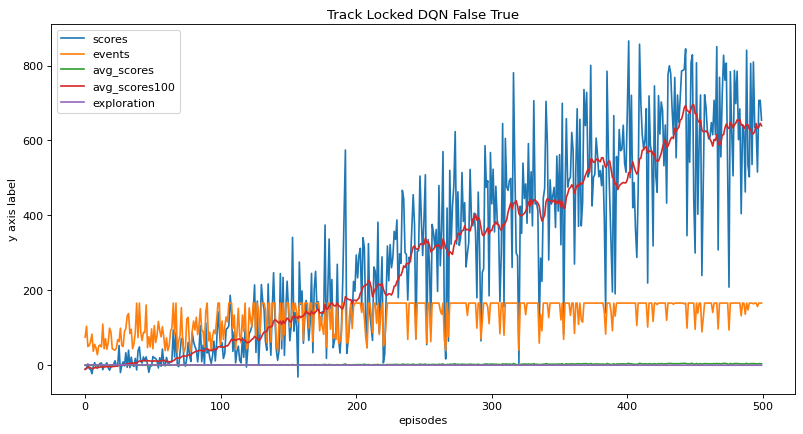

In [ ]:
figure(figsize=(12, 6), dpi=80)
plt.plot(episodes, scores)
plt.plot(episodes, events)
plt.plot(episodes, avg_scores)
plt.plot(episodes, avg_scores20)
plt.plot(episodes, exploration)
plt.xlabel('episodes')
plt.ylabel('y axis label')

plt.title('Track Locked DQN '+str(usedoubleDQN)+' '+str(useDueling))
plt.legend(['scores', 'events', 'avg_scores', 'avg_scores100','exploration'])
plt.show()

View Best Results

In [ ]:
createMovie(bestNet,'bestNet',UseRandomize,UseContinuousControl)




/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/videos/bestNet folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:297: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(


Moviepy - Building video /content/videos/bestNet/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/bestNet/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/bestNet/rl-video-episode-0.mp4
Moviepy - Building video /content/videos/bestNet/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/bestNet/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/bestNet/rl-video-episode-0.mp4


In [ ]:
def createMovie2(Network,Filename,UseRandomizer,UseContinuous):

    env1 = gym.make("CarRacing-v2", render_mode="rgb_array",domain_randomize=UseRandomizer, continuous=UseContinuous)
    envX = env1

    new_state = envX.reset(options={"randomize": UseRandomizer})#,seed=6)
    new_state, _ = envX.reset(options={"randomize": UseRandomizer})#,seed=6)


    stackedStateX=[np.rollaxis(new_state, 2, 0).copy() for i in range(FrameStack)];
    state =torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameSize*FrameStack,96,96)) ).float().to(device)


    i=0
    Network.eval()
    resetStatus=0;

    totalreward=0
    while True:
        action = Network.policy(state);
        reward=0
        for x in range(ControlSteps):
            new_state, r, done, truncated, _  = envX.step(action_space[action.item()])
            reward+=r
            if(done):
                break

        totalreward+=reward;
        stackedStateX.pop(0)

        stackedStateX.append(np.rollaxis(new_state, 2, 0).copy())
        state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameSize*FrameStack,96,96))).float().to(device)
        i=i+1;
        if done or truncated:
          break;

    envX.close()
    return totalreward;

In [ ]:
print(createMovie2(bestNet,'bestNet',False,UseContinuousControl))
print(createMovie2(bestNet,'bestNet',False,UseContinuousControl))
print(createMovie2(bestNet,'bestNet',False,UseContinuousControl))
print(createMovie2(bestNet,'bestNet',False,UseContinuousControl))
print(createMovie2(bestNet,'bestNet',False,UseContinuousControl))
print(createMovie2(bestNet,'bestNet',True,UseContinuousControl))
print(createMovie2(bestNet,'bestNet',True,UseContinuousControl))
print(createMovie2(bestNet,'bestNet',True,UseContinuousControl))
print(createMovie2(bestNet,'bestNet',True,UseContinuousControl))
print(createMovie2(bestNet,'bestNet',True,UseContinuousControl))


836.3558912386516
862.1824451410469
909.3999999999833
908.7999999999893
892.5272727272558
697.7797979797823
-93.98881987577533
146.71358024691716
-33.29859154929616
870.8144927536126
